# Waveform Feature Engineering

ChatGPT brainstorming: https://chatgpt.com/share/671bbf0a-6bd4-8005-9c19-b69fcc874e7f

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.signal as signal
import seaborn as sns
from scipy.spatial import distance
import neurokit2 as nk
import time

In [2]:
df_info = pd.read_csv("https://api.vitaldb.net/cases")
df_ids = pd.read_csv("https://api.vitaldb.net/trks")

In [3]:
def get_data_for(tid):
    data = pd.read_csv(f"https://api.vitaldb.net/{tid}")
    arr = np.array(data['SNUADC/ECG_II'])
    time_array = np.linspace(0, np.array(data['Time'])[-1], len(data))
    return time_array, arr

In [4]:
data = pd.read_csv('data_icu.csv')
data.head()

,caseid,subjectid,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,death_inhosp,age_group,icu_length,Mahalanobis
0,55,5077,18.0,175.1,59.2,0,292.55,1,0,0,3,0,child,1,2.082258
1,264,10,0.7,64.1,8.9,1,475.00,1,0,0,38,0,child,1,2.051887
2,280,5985,0.6,42.0,5.6,1,435.00,1,0,0,15,0,child,1,2.553821
3,366,10,0.8,64.1,8.9,1,115.00,1,0,0,38,0,child,1,1.676772
4,527,4603,18.0,185.0,62.6,0,210.00,1,0,0,1,0,child,0,1.775898


In [5]:
ecg_time, ecg_data = get_data_for("cedfc6b4610363ed0ac5a4ac4a23e007bda34fe6")
fs = 500
valid_data = ecg_data[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
valid_time = ecg_time[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
small_time = valid_time[15000:30000]
small_data = valid_data[15000:30000]

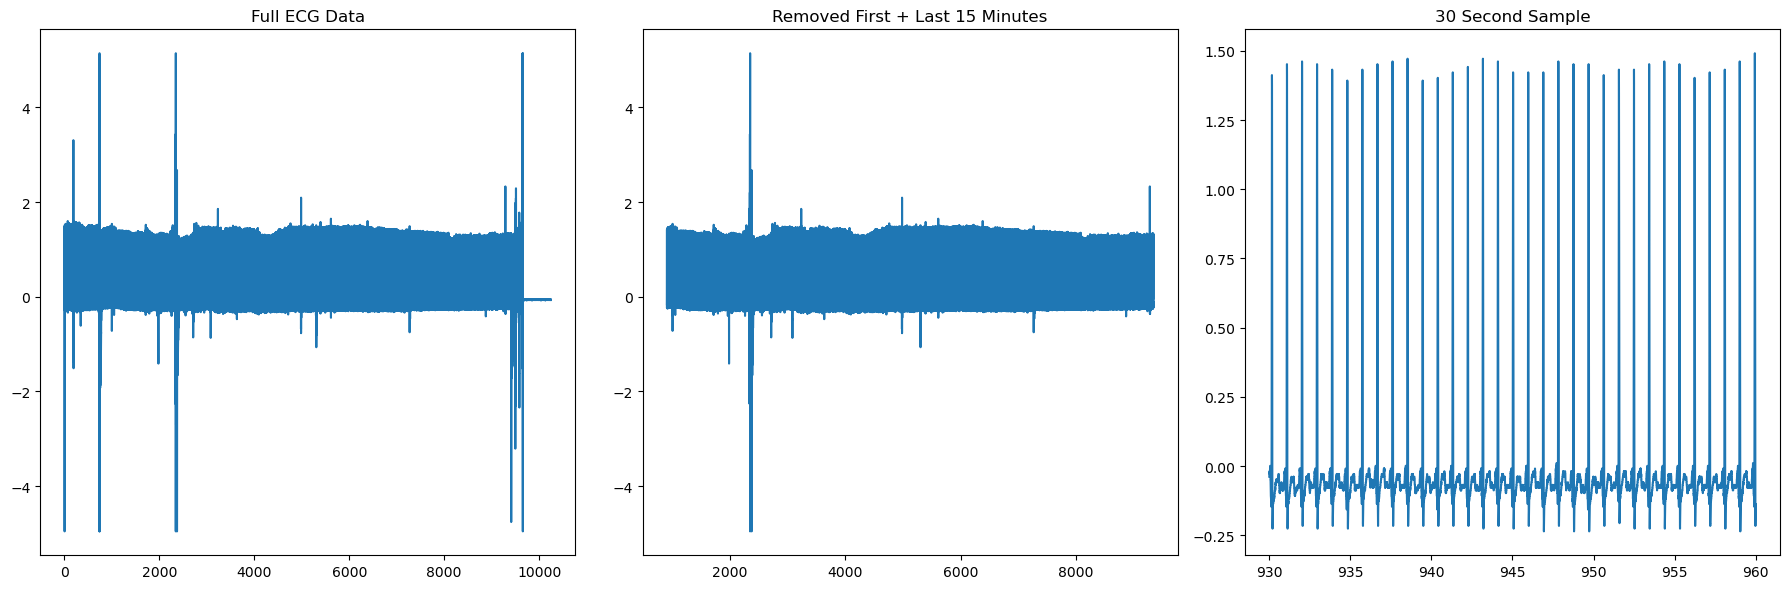

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].plot(ecg_time,ecg_data)
axs[0].set_title('Full ECG Data')
axs[1].plot(valid_time,valid_data)
axs[1].set_title('Removed First + Last 15 Minutes')
axs[2].plot(small_time,small_data)
axs[2].set_title('30 Second Sample')

plt.tight_layout()
plt.show()

# Approach 1: Sample Entropy

One idea for a feature is the *sample entropy* of the waveform. Sample Entropy is a measure of the complexity and irregularity of a time series. Essentially, it quantifies how predictable the data is over time. In a routine surgery, sample entropy for ECG data should be quite low. Higher sample entropy values indicate more complex and less predictable heart activity, while lower values suggest more regular and stable rhythms.

The original sample entropy has time complexity $O(n^2)$, which is far too slow for our very long signals. To shorten the time, we first downsampled the signal by a factor of 10 (essentially sampling at 50 Hz instead of 500 Hz) to reduce our number of data points. Then, we used segment-based sample entropy. Sample entropy compares every sample to every other sample, so by doing it in segments, we have a lot less to compare, and therefore a faster runtime. Finally, we took both the mean and the max of all of the samples, and we will see when we run this function on all of the data which one makes the most sense to use.

In [7]:
def calculate_sampen(signal, m, r):
    N = len(signal)
    
    def _phi(m):
        count = 0
        # create segments of length m
        for i in range(N - m):
            template = signal[i:i + m]
            # compare all segments to all other segments
            for j in range(i + 1, N - m):
                if np.max(np.abs(template - signal[j:j + m])) <= r:
                    count += 1
        return count / (N - m) / (N - m - 1)
    
    # formula for sample entropy
    return -np.log(_phi(m + 1) / _phi(m)) if _phi(m) > 0 else np.inf

In [8]:
def segment_based_sampen(ecg_signal, segment_length, m, r, downsample_factor=1):
    N = len(ecg_signal)
    num_segments = N // segment_length
    sampen_values = []
    
    for i in range(num_segments):
        # extract the segment
        segment = ecg_signal[i * segment_length : (i + 1) * segment_length]
        
        # downsample the segment
        if downsample_factor > 1:
            segment = segment[::downsample_factor]
        
        # calculate SampEn for the segment
        sampen_value = calculate_sampen(segment, m, r)
        sampen_values.append(sampen_value)
        
    return np.mean(sampen_values), np.max(sampen_values)

In [9]:
segment_length = 1000 # with downsampling, segments are 20 seconds
m = 2 # typical for ECG data
r = 0.2 * np.std(valid_data) # typical for ECG data
downsample_factor = 10

start_time1 = time.time()
mean_sampen, max_sampen = segment_based_sampen(valid_data, segment_length, m, r, downsample_factor)
end_time1 = time.time()

print(f"One Sample Entropy measure calculated in {end_time1 - start_time1:.3f} seconds")
print(f"Mean Sample Entropy: {mean_sampen}")
print(f"Maximum Sample Entropy: {max_sampen}")

One Sample Entropy measure calculated in 113.861 seconds
Mean Sample Entropy: 0.1555304471671046
Maximum Sample Entropy: 0.6787584431078458


This approach takes about 2 minutes for one patient, which means that even if we use the smaller dataset, it will take about 35 hours to run this for every patient.

# Approach 2: R-R intervals and RMSSD

The second method we explored for a waveform feature was related to *R-R intevals*. The waveform from ECG data is made up of three parts, known as the QRS complex. The RR interval is the time between two R peaks. Once we have the R-R intervals, we find the RMSSD, the root mean square of successive differences. This is a good measure because it is sensitive to short-term fluctuations. In this context, this means that it could accurately capture a short adverse event. According to ChatGPT, this is also a good metric because it reflects parasympathetic nervous system activity, which makes it it a good indicator of recovery potential and stress response.

Finding the R-R intervals takes a significant amount of time, and it is done with an external function, so there isn't really a way for us to make it faster. Once we have the R-R intervals, though, finding the RMSSD is easy and fast.

In [10]:
def rr_interval_rmssd(ecg_data, sampling_rate):
    ecg_cleaned = nk.ecg_clean(ecg_data, sampling_rate, method="neurokit")
    ecg_signals, ecg_info = nk.ecg_process(ecg_cleaned, sampling_rate)
    rpeaks = ecg_info['ECG_R_Peaks']
    rr_int = np.diff(rpeaks) / 500
    ma = np.convolve(rr_int, np.ones(50)/50)
    ma_sampled = [ma[15*i] for i in range(int(len(ma)/15))]
    diff = np.diff(ma_sampled)
    rmssd = np.sqrt(np.mean(diff**2))
    return rmssd

In [11]:
start_time2 = time.time()
rmssd = rr_interval_rmssd(valid_data, 500)
end_time2 = time.time()

print(f'One R-R interval measure calculated in {end_time2 - start_time2:.3f} seconds')
print(f'RMSSD: {rmssd}')

One R-R interval measure calculated in 30.458 seconds
RMSSD: 0.02963239484059367


This approach takes about 0.5 minutes for one patient, which means that even if we use the smaller dataset, it will take about 9 hours to run this for every patient.

# Comparing Patients

We want only measurements from patients in our dataset. We also had to remove 6 surgeries because they did not have ECG data, leaving us with 1136 instances.

In [12]:
patient_ecgs = df_ids[(df_ids['tname']=='SNUADC/ECG_II') & (df_ids['caseid'].isin(data['caseid']))]
patient_ecgs.head()

,caseid,tname,tid
279,4,SNUADC/ECG_II,be29325ee538657798f5c804bf72596fb3fd47ea
366,5,SNUADC/ECG_II,3431cd35ca4bc15b6de13e4c49b2db56e6bc5a37
521,7,SNUADC/ECG_II,f5bdb6cceb16a2f45ad0df54d3736126d7d076bd
754,10,SNUADC/ECG_II,c31fe646f6619757dec89dd37bdcf19731226366
1276,17,SNUADC/ECG_II,0eef4128d27d9a23c25b7658dfbece0dfeb4c596


In [13]:
print(f'{len(data[~data["caseid"].isin(patient_ecgs["caseid"])])} patients do not have ECG measurements')
data[~data["caseid"].isin(patient_ecgs["caseid"])]

6 patients do not have ECG measurements


,caseid,subjectid,Age,Ht,Wt,Sex,OP_time,Open,Robotic,Videoscopic,icu_days,death_inhosp,age_group,icu_length,Mahalanobis
231,2498,1915,51.0,153.6,68.5,1,155.00,0,0,1,1,0,adult,0,2.170664
346,3865,1622,54.0,172.2,68.1,0,190.00,0,0,1,1,0,adult,0,0.968997
374,4124,1888,58.0,173.6,53.5,0,155.00,1,0,0,1,0,adult,0,2.005130
856,3066,4648,76.0,168.1,70.3,0,57.15,1,0,0,4,0,elder,1,1.827845
889,3498,5920,69.0,160.0,61.3,1,155.00,0,0,1,1,0,elder,0,2.205778
980,4590,6013,71.0,163.5,64.6,0,235.00,0,0,1,1,0,elder,0,0.994796


In [14]:
data = data[data['caseid'].isin(patient_ecgs['caseid'])]

Before looking at all the patients, we compare 5 just to see some comparisons.

In [15]:
for i, row in patient_ecgs.iloc[:5].iterrows():
    ecg_time, ecg_data = get_data_for(row['tid'])
    fs = 500
    valid_data = ecg_data[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
    valid_time = ecg_time[(ecg_time > 900) & (ecg_time < ecg_time[-1]-900)]
    segment_length = 1000 # with downsampling, segments are 20 seconds
    m = 2 # typical for ECG data
    r = 0.2 * np.std(valid_data) # typical for ECG data
    downsample_factor = 10
    
    print(f'\nCASE {i}\n')
    
    start_time1 = time.time()
    mean_sampen, max_sampen = segment_based_sampen(valid_data, segment_length, m, r, downsample_factor)
    end_time1 = time.time()

    print(f"Sample Entropy calculated in {end_time1 - start_time1:.3f} seconds")
    print(f"Mean Sample Entropy: {mean_sampen}")
    print(f"Maximum Sample Entropy: {max_sampen}\n")
    
    start_time2 = time.time()
    rmssd = rr_interval_rmssd(valid_data, 500)
    end_time2 = time.time()

    print(f'R-R interval measure calculated in {end_time2 - start_time2:.3f} seconds')
    print(f'RMSSD: {rmssd}\n')
    


CASE 279

Sample Entropy calculated in 79.149 seconds
Mean Sample Entropy: inf
Maximum Sample Entropy: inf



/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 9550 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by

R-R interval measure calculated in 117.469 seconds
RMSSD: 0.01653802088935859


CASE 366

Sample Entropy calculated in 245.085 seconds
Mean Sample Entropy: 0.4555916365156369
Maximum Sample Entropy: 2.0996442489973557

R-R interval measure calculated in 132.756 seconds
RMSSD: 0.015811151614750125


CASE 521

Sample Entropy calculated in 59.250 seconds
Mean Sample Entropy: inf
Maximum Sample Entropy: inf



/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/ecg/ecg_clean.py:106: NeuroKitWarning: There are 7187 missing data points in your signal. Filling missing values by using the forward filling method.
  warn(


R-R interval measure calculated in 50.920 seconds
RMSSD: 0.027187185641212145


CASE 754



/var/folders/v_/x9g5rqbn6rq7sdnq6dcr2zc80000gn/T/ipykernel_78098/3092496816.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(_phi(m + 1) / _phi(m)) if _phi(m) > 0 else np.inf


Sample Entropy calculated in 240.255 seconds
Mean Sample Entropy: inf
Maximum Sample Entropy: inf

R-R interval measure calculated in 101.935 seconds
RMSSD: 0.015238826770211373


CASE 1276



/var/folders/v_/x9g5rqbn6rq7sdnq6dcr2zc80000gn/T/ipykernel_78098/3092496816.py:16: RuntimeWarning: divide by zero encountered in log
  return -np.log(_phi(m + 1) / _phi(m)) if _phi(m) > 0 else np.inf


Sample Entropy calculated in 230.655 seconds
Mean Sample Entropy: inf
Maximum Sample Entropy: inf



/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
/Users/dylanmack/anaconda3/lib/python3.11/site-packages/neurokit2/signal/signal_fixpeaks.py:307: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


R-R interval measure calculated in 97.832 seconds
RMSSD: 0.018036625423534156

